In [145]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np

import librosa 
import librosa.display
import pylab
import cv2
import os

## contrastive learning

In [11]:
con_coughvid  = './public_dataset/'
con_custpath  = './custom_dataset/' #Where mel spec images will be stored

con_VidData   = pd.read_csv(os.path.join(con_coughvid,'metadata_compiled.csv'),header=0)
con_VidData   = con_VidData.loc[con_VidData['cough_detected'] >= 0.7][['uuid']]
con_VidData.dropna(inplace=True)

con_TotData   = con_VidData 
con_TotData['DIR'] = con_coughvid + con_TotData['uuid'] + '.wav'
con_TotData['DataSet'] = 'coughvid'
con_TotData   = pd.concat([con_TotData.rename(columns={'uuid':'ID'})])
con_TotData   = con_TotData.sample(frac=1).reset_index(drop=True)
con_TotData.head()

,ID,DIR,DataSet
0,15704523-4a4e-43f0-9b25-47d6a674f9ff,./public_dataset/15704523-4a4e-43f0-9b25-47d6a...,coughvid
1,565c00d9-52e3-4899-8e45-74b6874c4452,./public_dataset/565c00d9-52e3-4899-8e45-74b68...,coughvid
2,fa3cbd89-2f5f-4cd4-b731-8449b7df5056,./public_dataset/fa3cbd89-2f5f-4cd4-b731-8449b...,coughvid
3,323476bf-8561-4862-82b8-d414ff20eab2,./public_dataset/323476bf-8561-4862-82b8-d414f...,coughvid
4,7427c5d6-acfd-4f9d-8fa2-ff31f7b390c6,./public_dataset/7427c5d6-acfd-4f9d-8fa2-ff31f...,coughvid


In [16]:
def feature_extractor(row):
    name     = row[0]
    try:
        audio,sr = librosa.load(row[-2])
        #Mel Spectogram
        pylab.axis('off') # no axis
        pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
        melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
        s_db     = librosa.power_to_db(melspec, ref=np.max)
        librosa.display.specshow(s_db)

        savepath = os.path.join(con_custpath,name+'.png')
        pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
        pylab.close()
    except:
        print('File cannot open')
        return None,None
    return savepath

imgpaths = []

In [17]:
for row in tqdm(con_TotData.values):
    savepath  = feature_extractor(row)
    imgpaths.append(savepath)

100%|██████████| 16441/16441 [2:11:16<00:00,  2.09it/s]  


In [18]:
isnone = lambda x: x is not None
cast_x = list(map(isnone,imgpaths))
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]

In [32]:
remove_data_list=[]
for i in sup_data_xx:
    dir_sup = i
    remove_data = dir_sup[21:]
    remove_data_list.append(remove_data)

In [33]:
contras_data_list=[]
for i in data_xx:
    dir_contras = i
    contras_data = dir_contras[17:]
    contras_data_list.append(contras_data)

In [34]:
for v in contras_data_list:
    if v in remove_data_list:
        contras_data_list.remove(v)       
len(contras_data_list)

14915

In [35]:
indices = np.arange(len(data_xx))
NUM_shuf= 5
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
    np.random.shuffle(indices)
    DATA[i]['MEL']   = [data_xx[i] for i in indices]

In [146]:
import pickle
with open('loaded_data.pickle', 'rb') as f:
    DATA = pickle.load(f) 

In [149]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles, batch_size,target_size=(64,64,3),shuffle=False,scale=255,n_classes=1,n_channels=3):
        self.batch_size = batch_size
        self.dim        = target_size
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, x = self.__data_generation(indexes)
        return X, x

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def block_masking(self, wav, T=20, F=15, time_mask_num=1, freq_mask_num=1):
        feat_size = wav.shape[0]
        seq_len = wav.shape[1]
        for _ in range(time_mask_num):
            t = np.random.uniform(low=0.0, high=T)
            t = int(t)
            t0 = random.randint(0, seq_len - t)
            for _ in range(freq_mask_num):
                f = np.random.uniform(low=0.0, high=F)
                f = int(f)
                f0 = random.randint(0, feat_size - f)
                
                wav[t0 : t0 + t, f0 : f0 + f] = 0
        return wav            
    
    def spec_augment(self, wav, T=20, F=15, time_mask_num=2, freq_mask_num=2):
        feat_size = wav.shape[0]
        seq_len = wav.shape[1]
          # freq mask
#         for _ in range(time_mask_num):
#             t = np.random.uniform(low=0.0, high=T)
#             t = int(t)
#             t0 = random.randint(0, seq_len - t)
#             wav[t0 : t0 + t] = 0
        # time mask
        for _ in range(freq_mask_num):
            f = np.random.uniform(low=0.0, high=F)
            f = int(f)
            f0 = random.randint(0, feat_size - f)
            wav[:, f0 : f0 + f] = 0
        return wav

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        x = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#             img = np.expand_dims(img, axis=-1)
            img = self.block_masking(img)
            
            img2   = cv2.imread(self.imgfiles[ID])
#             img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            img2   = cv2.resize(img2,self.dim,interpolation = cv2.INTER_CUBIC)
#             img2 = np.expand_dims(img2, axis=-1)
            img2 = self.spec_augment(img2)
            
            X[i,] = img / self.scale
            x[i,] = img2 / self.scale

            self.c +=1
        return X, x #keras.utils.to_categorical(y, num_classes=self.n_classes)
    
class specGenerator(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, batch_size,target_size=(64,64)):
        self.genX2 = CustomDataset(X2,batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, X_2_batch = self.genX2.__getitem__(index)
        return X_batch, X_2_batch

In [148]:
img   = cv2.imread("./sup_custom_dataset/ZTlauEp4EjMLV0LKWsxXnRopWvC3.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.expand_dims(img, axis=-1)
img.shape

(288, 432, 1)

## model

#### 3channel

In [113]:
def build_model():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

    # Second Model
    inp2   = Input(shape=(64,64,3))
    lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
    lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
    lay3_  = BatchNormalization()(lay2_)
    lay4_  = Activation('relu')(lay3_)

    lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
    lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
    lay7_  = BatchNormalization()(lay6_)
    lay8_  = Activation('relu')(lay7_)

    lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
    lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
    lay11_ = BatchNormalization()(lay10_)
    lay12_ = Activation('relu')(lay11_)

    lay13_ = Flatten()(lay12_)
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
    lay15_ = Dropout(rate=0.3)(lay14_)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    # projection head
    x = tf.keras.layers.Dense(256)(lay13_)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)
    MERGM   = Model(inputs=inp2, outputs=lay15_)

    return MERGM

#### 1channel

In [94]:
def build_model_1():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

    # Second Model
    inp2   = Input(shape=(64,64,1))
    lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
    lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
    lay3_  = BatchNormalization()(lay2_)
    lay4_  = Activation('relu')(lay3_)

    lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
    lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
    lay7_  = BatchNormalization()(lay6_)
    lay8_  = Activation('relu')(lay7_)

    lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
    lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
    lay11_ = BatchNormalization()(lay10_)
    lay12_ = Activation('relu')(lay11_)

    lay13_ = Flatten()(lay12_)
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
    lay15_ = Dropout(rate=0.5)(lay14_)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    # projection head
    x = tf.keras.layers.Dense(256)(lay13_)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)
    MERGM   = Model(inputs=inp2, outputs=lay15_)

    return MERGM

In [150]:
def ResNetSimCLR(base_model='resnet18'):
    inputs = tf.keras.layers.Input(shape=(64,64,3))

    base_encoder = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=None,
                                                  input_shape=None, pooling='avg')
    base_encoder.training = True
    h = base_encoder(inputs)

    # projection head
    x = tf.keras.layers.Dense(256)(h)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [38]:
def EfficientSimCLR(base_model='efficient'):
    inputs = tf.keras.layers.Input(shape=(64,64,3))

    base_encoder = tf.keras.applications.EfficientNetB0(include_top=False, weights=None, input_tensor=None,
                                                        input_shape=None, pooling='avg')
    base_encoder.training = True
    h = base_encoder(inputs)

    # projection head
    x = tf.keras.layers.Dense(256)(h)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [151]:
import tensorflow.keras.backend as K

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return v


def _cosine_simililarity_dim2(x, y):
    # x shape: (N, 1, C)
    # y shape: (1, 2N, C)
    # v shape: (N, 2N)
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return v


def _dot_simililarity_dim1(x, y):
    # x shape: (N, 1, C)
    # y shape: (N, C, 1)
    # v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def _dot_simililarity_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C)
    # y shape: (1, C, 2N)
    # v shape: (N, 2N)
    return v

cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)


def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return v


def _cosine_simililarity_dim2(x, y):
    # x shape: (N, 1, C)
    # y shape: (1, 2N, C)
    # v shape: (N, 2N)
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return v


def _dot_simililarity_dim1(x, y):
    # x shape: (N, 1, C)
    # y shape: (N, C, 1)
    # v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def _dot_simililarity_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C)
    # y shape: (1, C, 2N)
    # v shape: (N, 2N)
    return v

def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)

In [152]:
# Create directory to save models
import tensorflow as tf
import datetime
import os
import yaml
import time
import shutil
import random
import matplotlib.pyplot as plt

NUM_shuf= 1

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    MERGM = ResNetSimCLR()
    
    timgs     = DATA[RUN]['MEL']
    imgs_em  = specGenerator(timgs,batch_size=1028,target_size=(64,64))
    
    negative_mask = get_negative_mask(1028)
    
    train_log_dir = os.path.join('logs_resnet', 'train')
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    optimizer = tf.keras.optimizers.Adam(0.0001)


    def train_step(xis, xjs):
        with tf.GradientTape() as tape:

            zis = MERGM(xis)
            zjs = MERGM(xjs)

            # normalize projection feature vectors
            zis = tf.math.l2_normalize(zis, axis=1)
            zjs = tf.math.l2_normalize(zjs, axis=1)

            # tf.summary.histogram('zis', zis, step=optimizer.iterations)
            # tf.summary.histogram('zjs', zjs, step=optimizer.iterations)

            l_pos = _dot_simililarity_dim1(zis, zjs)
            l_pos = tf.reshape(l_pos, (1028, 1))
            l_pos /= 0.5
#             assert l_pos.shape == (48, 1), "l_pos shape not valid" + str(l_pos.shape)  # [N,1]

            negatives = tf.concat([zjs, zis], axis=0)

            loss = 0

            for positives in [zis, zjs]:
                l_neg = _dot_simililarity_dim2 (positives, negatives)

                labels = tf.zeros(1028, dtype=tf.int32)

                l_neg = tf.boolean_mask(l_neg, negative_mask)
                l_neg = tf.reshape(l_neg, (1028, -1))
                l_neg /= 0.5

#                 assert l_neg.shape == (
#                     48, 2 * (48 - 1)), "Shape of negatives not expected." + str(
#                     l_neg.shape)
                logits = tf.concat([l_pos, l_neg], axis=1)  # [N,K+1]
                loss += criterion(y_pred=logits, y_true=labels)

            loss = loss / (2 * 1028)
            tf.summary.scalar('loss', loss, step=optimizer.iterations)
            print('loss',loss)

        gradients = tape.gradient(loss, MERGM.trainable_variables)
        optimizer.apply_gradients(zip(gradients, MERGM.trainable_variables))


    with train_summary_writer.as_default():
        for xis, xjs in imgs_em:
#             print(tf.reduce_min(xis), tf.reduce_max(xjs))
#             fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=False)
#             axs[0, 0].imshow(xis[1])
#             axs[0, 1].imshow(xjs[1])

#             axs[1, 0].imshow(xis[8])
#             axs[1, 1].imshow(xjs[8])
#             plt.show()
#             start = time.time()
            train_step(xis, xjs)
#             end = time.time()
#             print("Total time per batch:", end - start)

    model_checkpoints_folder = os.path.join(train_log_dir, 'checkpoints')
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
    a = 'model'+ str(RUN+1) + '.h5'    
    MERGM.save(os.path.join(model_checkpoints_folder, a))

loss tf.Tensor(7.568298, shape=(), dtype=float32)
loss tf.Tensor(7.314779, shape=(), dtype=float32)
loss tf.Tensor(7.1316414, shape=(), dtype=float32)
loss tf.Tensor(6.922606, shape=(), dtype=float32)
loss tf.Tensor(6.785735, shape=(), dtype=float32)
loss tf.Tensor(6.7003417, shape=(), dtype=float32)
loss tf.Tensor(6.6265173, shape=(), dtype=float32)
loss tf.Tensor(6.5747905, shape=(), dtype=float32)
loss tf.Tensor(6.5118775, shape=(), dtype=float32)
loss tf.Tensor(6.607361, shape=(), dtype=float32)
loss tf.Tensor(6.5531535, shape=(), dtype=float32)
loss tf.Tensor(6.5159235, shape=(), dtype=float32)
loss tf.Tensor(6.521831, shape=(), dtype=float32)
loss tf.Tensor(6.447608, shape=(), dtype=float32)
loss tf.Tensor(6.415743, shape=(), dtype=float32)


## supervised learning

In [177]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('../Coswara-Data-master/coswara/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('../Coswara-Data-master/*/*/cough-shallow.wav')):
    temp = pd.DataFrame(columns=['id','DIR'])
    temp['id'] = [path.split('/')[-2]]
    temp['DIR'] = [path]
    temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

    temp['fomp']= (temp['fever']| temp['mp']).apply(int)
    temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
    temp        = temp[['id','covid_status','DIR','fomp','oths']]
    df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData=pd.concat(df_list)
CosData['DataSet'] = 'coswara'
CosData.head()

100%|██████████| 1644/1644 [00:12<00:00, 130.97it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,5ZDF98UQUxcVuS9VhaWxKlVnXvs1,no_resp_illness_exposed,../Coswara-Data-master/20200413/5ZDF98UQUxcVuS...,0,0,coswara
0,FGRDO4IBbAejR0WHD5YbkXTCasg2,healthy,../Coswara-Data-master/20200413/FGRDO4IBbAejR0...,0,0,coswara
0,CAf8ILsDpQMeTPPLwi7nFlgRT2t1,healthy,../Coswara-Data-master/20200413/CAf8ILsDpQMeTP...,0,0,coswara
0,aGEXEhp3mbUandZBtCuEooDQrK53,healthy,../Coswara-Data-master/20200413/aGEXEhp3mbUand...,0,0,coswara
0,uMry1yqi5sNoykw7ySJdITMv2yT2,resp_illness_not_identified,../Coswara-Data-master/20200413/uMry1yqi5sNoyk...,0,0,coswara


In [179]:
temp['DIR'][0]

'../Coswara-Data-master/20200424/C5eIsssb9GSkaAgIfsHMHeR6fSh1/cough-shallow.wav'

In [3]:
coughvid  = './public_dataset/'
custpath  = './sup_custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19'][0:1000]

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.wav'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,09de6967-b295-4516-8a4d-4d95c9a7b02c,symptomatic,./public_dataset/09de6967-b295-4516-8a4d-4d95c...,0,0,coughvid
1,joORHxc0iCTwgP7Uh5SM5N7rnnf2,positive_moderate,../Coswara-Data-master/20201012/joORHxc0iCTwgP...,1,1,coswara
2,spM6cgJG4VQfYjnnTqxwx3Cg3pk1,healthy,../Coswara-Data-master/20200502/spM6cgJG4VQfYj...,0,0,coswara
3,7023acad-4e24-444b-b0a6-a3aa54bd321b,COVID-19,./public_dataset/7023acad-4e24-444b-b0a6-a3aa5...,0,0,coughvid
4,1adc614f-9f34-451c-ac33-47a411f0a06d,COVID-19,./public_dataset/1adc614f-9f34-451c-ac33-47a41...,0,0,coughvid


In [44]:
count=0
for i in TotData['STATUS'] :
    print(i) 
    count+=1
print(count)

symptomatic
positive_moderate
healthy
COVID-19
COVID-19
COVID-19
symptomatic
healthy
healthy
healthy
healthy
no_resp_illness_exposed
healthy
healthy
no_resp_illness_exposed
positive_mild
healthy
healthy
COVID-19
COVID-19
healthy
healthy
positive_mild
healthy
healthy
COVID-19
healthy
healthy
positive_asymp
healthy
COVID-19
no_resp_illness_exposed
healthy
COVID-19
healthy
COVID-19
healthy
healthy
COVID-19
COVID-19
COVID-19
COVID-19
healthy
COVID-19
healthy
healthy
COVID-19
healthy
recovered_full
healthy
healthy
COVID-19
healthy
healthy
healthy
healthy
no_resp_illness_exposed
healthy
healthy
healthy
healthy
healthy
healthy
COVID-19
healthy
healthy
symptomatic
resp_illness_not_identified
healthy
healthy
healthy
COVID-19
symptomatic
healthy
healthy
COVID-19
resp_illness_not_identified
symptomatic
healthy
healthy
COVID-19
healthy
healthy
COVID-19
healthy
symptomatic
healthy
healthy
healthy
healthy
healthy
healthy
healthy
healthy
healthy
healthy
healthy
healthy
no_resp_illness_exposed
healthy

healthy
healthy
healthy
healthy
COVID-19
healthy
healthy
COVID-19
COVID-19
healthy
healthy
resp_illness_not_identified
healthy
healthy
healthy
healthy
healthy
positive_mild
healthy
healthy
healthy
COVID-19
COVID-19
healthy
COVID-19
healthy
healthy
positive_mild
healthy
healthy
healthy
healthy
healthy
COVID-19
COVID-19
COVID-19
healthy
COVID-19
healthy
healthy
healthy
healthy
COVID-19
healthy
COVID-19
COVID-19
COVID-19
healthy
healthy
healthy
healthy
healthy
healthy
no_resp_illness_exposed
healthy
symptomatic
healthy
healthy
healthy
healthy
healthy
healthy
positive_mild
COVID-19
no_resp_illness_exposed
healthy
healthy
healthy
healthy
healthy
COVID-19
resp_illness_not_identified
no_resp_illness_exposed
COVID-19
healthy
symptomatic
healthy
healthy
healthy
healthy
healthy
healthy
healthy
COVID-19
COVID-19
healthy
healthy
healthy
healthy
COVID-19
COVID-19
COVID-19
healthy
healthy
healthy
healthy
no_resp_illness_exposed
healthy
COVID-19
symptomatic
COVID-19
positive_moderate
positive_mild
he

In [5]:
def sup_feature_extractor(row):
    name     = row[0]
    try:
        audio,sr = librosa.load(row[-4])
        #For MFCCS 
        mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
        mfccsscaled = np.mean(mfccs.T,axis=0)

        #Mel Spectogram
        pylab.axis('off') # no axis
        pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
        melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
        s_db     = librosa.power_to_db(melspec, ref=np.max)
        librosa.display.specshow(s_db)

        savepath = os.path.join(custpath,name+'.png')
        pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
        pylab.close()
    except:
        print('File cannot open')
        return None,None
    return mfccsscaled,savepath

sup_features = []
sup_diagnoses= []
sup_imgpaths = []

In [6]:
for row in tqdm(TotData.values):
    mfccs,savepath  = sup_feature_extractor(row)
    sup_features.append(mfccs)
    sup_imgpaths.append(savepath)
    sup_diagnoses.append([row[3],row[4]])

  4%|▍         | 128/3343 [00:42<19:07,  2.80it/s]

File cannot open


  5%|▌         | 171/3343 [00:55<08:43,  6.06it/s]

File cannot open
File cannot open


  6%|▌         | 194/3343 [01:02<13:36,  3.86it/s]

File cannot open


  9%|▉         | 303/3343 [01:36<17:48,  2.84it/s]

File cannot open


 10%|▉         | 332/3343 [01:44<12:46,  3.93it/s]

File cannot open


 15%|█▍        | 492/3343 [02:35<15:20,  3.10it/s]

File cannot open


 20%|█▉        | 653/3343 [03:25<10:40,  4.20it/s]

File cannot open


 23%|██▎       | 763/3343 [03:58<10:56,  3.93it/s]

File cannot open


 23%|██▎       | 783/3343 [04:04<07:21,  5.80it/s]

File cannot open


 28%|██▊       | 951/3343 [04:56<13:24,  2.97it/s]

File cannot open


 29%|██▉       | 963/3343 [05:00<10:15,  3.87it/s]

File cannot open


 33%|███▎      | 1088/3343 [05:38<12:58,  2.90it/s]

File cannot open


 36%|███▌      | 1209/3343 [06:17<10:31,  3.38it/s]

File cannot open


 36%|███▋      | 1213/3343 [06:18<05:55,  6.00it/s]

File cannot open


 45%|████▍     | 1498/3343 [07:45<07:21,  4.18it/s]

File cannot open


 49%|████▉     | 1645/3343 [08:34<09:11,  3.08it/s]

File cannot open


 52%|█████▏    | 1724/3343 [08:58<09:22,  2.88it/s]

File cannot open


 52%|█████▏    | 1744/3343 [09:03<07:14,  3.68it/s]

File cannot open


 63%|██████▎   | 2115/3343 [11:03<06:47,  3.02it/s]

File cannot open


 76%|███████▌  | 2527/3343 [13:18<03:38,  3.74it/s]

File cannot open


 78%|███████▊  | 2616/3343 [13:46<03:47,  3.19it/s]

File cannot open


 82%|████████▏ | 2752/3343 [14:29<01:46,  5.55it/s]

File cannot open


 83%|████████▎ | 2773/3343 [14:35<02:39,  3.57it/s]

File cannot open


 87%|████████▋ | 2896/3343 [15:15<02:22,  3.14it/s]

File cannot open


 95%|█████████▍| 3164/3343 [16:44<00:56,  3.18it/s]

File cannot open


 99%|█████████▉| 3303/3343 [17:27<00:15,  2.64it/s]

File cannot open


 99%|█████████▉| 3315/3343 [17:30<00:07,  3.64it/s]

File cannot open


100%|██████████| 3343/3343 [17:39<00:00,  3.16it/s]


In [181]:
isnone = lambda x: x is not None
sup_label  = lambda xx: 1 if xx == 'positive_mild' or xx =='positive_moderate' or xx == 'COVID-19' else 0
sup_cast_x = list(map(isnone,sup_features))
sup_data_y = list(map(sup_label,TotData['STATUS']))

sup_data_x = [sup_features[i] for i in range(len(sup_features)) if sup_cast_x[i] == True]
sup_data_xx= [sup_imgpaths[i] for i in range(len(sup_imgpaths)) if sup_cast_x[i] == True]
sup_data_xp= [sup_diagnoses[i]for i in range(len(sup_diagnoses))if sup_cast_x[i] == True]
sup_data_y = [sup_data_y[i] for i in range(len(sup_features)) if sup_cast_x[i] == True]

NameError: name 'sup_features' is not defined

In [8]:
positive=0
negetive=0

for i in sup_data_y :
    if i == 0:
        negetive +=1
    else:
        positive +=1
print('negetive:',negetive)
print('positive:',positive)

negetive: 2500
positive: 815


In [9]:
assert len(sup_data_x) == len(sup_data_xx) == len(sup_data_xp), "Data lengths do not match"

sup_indices = np.arange(len(sup_data_x))
NUM_shuf= 5
sup_DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
    np.random.shuffle(sup_indices)

    sup_DATA[i]['MFCCS'] = np.array([sup_data_x[i] for i in sup_indices])
    sup_DATA[i]['MEL']   = [sup_data_xx[i] for i in sup_indices]
    sup_DATA[i]['EXTRA'] = np.array([sup_data_xp[i] for i in sup_indices])
    sup_DATA[i]['LABELS']= np.array([sup_data_y[i] for i in sup_indices])

In [180]:
sup_DATA

{0: {'MFCCS': array([[-4.4081580e+02,  5.3827419e+01, -1.7568724e+01, ...,
          -1.5146372e+00, -1.8026236e+00, -9.7484857e-01],
         [-4.1166214e+02,  4.3993874e+01, -1.8312914e+01, ...,
           9.7204693e-02,  9.7496378e-01,  9.8592699e-01],
         [-3.5480844e+02,  7.1629066e+01, -6.0014557e+01, ...,
          -2.2583486e-01,  7.5975016e-02, -8.7329209e-01],
         ...,
         [-3.7196725e+02,  3.9683044e+01, -2.4552366e+01, ...,
          -1.3235413e+00,  1.9736396e+00,  7.7590150e-01],
         [-3.7439697e+02,  4.7605953e+01, -1.7743137e+01, ...,
           2.6871088e+00, -3.3188879e-01,  1.3411318e-01],
         [-4.0077756e+02,  6.5835083e+01, -1.9945971e+01, ...,
           4.0447125e-01, -6.0569137e-01, -5.1727265e-01]], dtype=float32),
  'MEL': ['./sup_custom_dataset/5bbd361a-f7ab-4397-9eec-e76a4758489d.png',
   './sup_custom_dataset/1579b93d-0ee3-4484-975c-a8777c0b6739.png',
   './sup_custom_dataset/7023acad-4e24-444b-b0a6-a3aa54bd321b.png',
   './sup_cust

In [10]:
import pickle
pickle.dump( sup_DATA, open( "sup_loaded_data.pickle", "wb" ) )b

In [153]:
import pickle
with open('sup_loaded_data.pickle', 'rb') as f:
    sup_DATA = pickle.load(f) 

## learning

In [154]:
class sup_CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    min_level_db= -100        
    def normalize_mel(self,S):
        return np.clip((S-min_level_db)/-min_level_db,0,1)


    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#             img   = self.normalize_mel(img)
#             img = np.expand_dims(img, axis=-1)
            X[i,] = img / self.scale

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)
    
class sup_specGenerator(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, Y, batch_size,target_size=(64,64)):
        self.genX2 = sup_CustomDataset(X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, Y_batch = self.genX2.__getitem__(index)
        return X_batch, Y_batch

In [155]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback

class Evaluation(Callback):
    def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
        super(Evaluation, self).__init__()
        self.test_data = test_data_gen
        self.val_labels = val_labels
        self.val_data = val_data_gen
        self.test_labels = test_labels

    def on_epoch_end(self, epoch, logs=None):
        y_preds = self.model.predict_generator(self.val_data)
        print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

        y_preds = self.model.predict_generator(self.test_data)
        print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [156]:
def sup_build_model():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

#     # Second Model
#     inp2   = Input(shape=(64,64,3))
#     lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
#     lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
#     lay3_  = BatchNormalization()(lay2_)
#     lay4_  = Activation('relu')(lay3_)

#     lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
#     lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
#     lay7_  = BatchNormalization()(lay6_)
#     lay8_  = Activation('relu')(lay7_)

#     lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
#     lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
#     lay11_ = BatchNormalization()(lay10_)
#     lay12_ = Activation('relu')(lay11_)

#     lay13_ = Flatten()(lay12_)
#     lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
#     lay15_ = Dropout(rate=0.5)(lay14_)

    inp2   = Input(shape=(64,64,3))
    base_encoder = keras.models.load_model("./logs_resnet/train/checkpoints/model1.h5"")
    base_encoder.trainable = False
    
    h = base_encoder(inp2,training=False)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(h)
    output  = Dense(1, activation='sigmoid')(lay14_)
    sup_MERGM   = Model(inputs=inp2, outputs=output)

    return sup_MERGM

SyntaxError: EOL while scanning string literal (<ipython-input-156-e67b258a61d9>, line 32)

In [107]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(sup_labels),
                                                 sup_labels)

class_weights

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[1 0 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


array([0.66475645, 2.0173913 ])

In [174]:
# Create directory to save models
rt_sv_dir = './downstream_resnet_class_weight'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)
NUM_shuf= 1

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    with tf.device("/gpu:0"):    
        sup_MERGM = sup_build_model()

        Adam = tf.keras.optimizers.Adam(0.005)
                                        

        sup_MERGM.compile(
          optimizer = Adam,
          loss = 'BinaryCrossentropy',
            metrics=['AUC'])

        sup_data_size = len(sup_DATA[RUN]['MFCCS'])

        sup_tfeatures = sup_DATA[RUN]['MFCCS'][:int(0.7*sup_data_size)]
        sup_textra    = sup_DATA[RUN]['EXTRA'][:int(0.7*sup_data_size)]
        sup_timgs     = sup_DATA[RUN]['MEL'][:int(0.7*sup_data_size)]
        sup_labels    = sup_DATA[RUN]['LABELS'][:int(0.7*sup_data_size)]

        sup_test_features= sup_DATA[RUN]['MFCCS'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
        sup_test_extra   = sup_DATA[RUN]['EXTRA'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
        sup_test_imgs    = sup_DATA[RUN]['MEL'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
        sup_test_labels  = sup_DATA[RUN]['LABELS'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]

        
        sup_val_features= sup_DATA[RUN]['MFCCS'][ int(0.85*sup_data_size) :]
        sup_val_extra   = sup_DATA[RUN]['EXTRA'][ int(0.85*sup_data_size) :]
        sup_val_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*sup_data_size) :]
        sup_val_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*sup_data_size) :]

        sup_imgs_em      = sup_specGenerator(sup_timgs,sup_labels,batch_size=32,target_size=(64,64))
        TEST          = sup_specGenerator(sup_test_imgs,sup_test_labels,batch_size=32,target_size=(64,64))
        VAL         = sup_specGenerator(sup_val_imgs,sup_val_labels,batch_size=32,target_size=(64,64))
        tf.random.set_seed(12)


        evaluator = Evaluation(VAL, sup_val_labels, TEST, sup_test_labels)
        checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                    "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
        os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
        class_weight = {0: 0.66475645, 1:2.0173913}
        history = sup_MERGM.fit_generator(
                      sup_imgs_em,
                      epochs=20,
                      validation_data=VAL, 
                      verbose=2, 
                      callbacks=[evaluator, checkpointer],class_weight=class_weight)
        historys[RUN]=history.history

        sup_MERGM_Record1 = sup_MERGM.evaluate_generator(
        TEST
        )

        print()
        print('Results: Loss = {} , AUC = {} '.format(sup_MERGM_Record1[0],sup_MERGM_Record1[1]))

        print()
        from sklearn.metrics import roc_auc_score


        y_val  = sup_val_labels
        y_preds_val = sup_MERGM.predict_generator(VAL)
        print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

        y_test  = sup_test_labels
        y_preds_test = sup_MERGM.predict(TEST)
        print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
        print()
        print('-----------------------------------------------------------------')

Epoch 1/20
 | val_auc: 0.5578391335227273
 | test_auc: 0.5908289241622575
72/72 - 10s - loss: 0.6908 - auc: 0.5507 - val_loss: 0.7942 - val_auc: 0.5585
Epoch 2/20
 | val_auc: 0.6109952059659091
 | test_auc: 0.5679271708683473
72/72 - 9s - loss: 0.6839 - auc: 0.5811 - val_loss: 0.6883 - val_auc: 0.6105
Epoch 3/20
 | val_auc: 0.6365189985795454
 | test_auc: 0.5878462496109554
72/72 - 9s - loss: 0.6706 - auc: 0.6293 - val_loss: 0.6978 - val_auc: 0.6364
Epoch 4/20
 | val_auc: 0.6587357954545455
 | test_auc: 0.6192032368502958
72/72 - 9s - loss: 0.6620 - auc: 0.6450 - val_loss: 0.6843 - val_auc: 0.6594
Epoch 5/20
 | val_auc: 0.6755149147727273
 | test_auc: 0.6296555659300758
72/72 - 9s - loss: 0.6518 - auc: 0.6720 - val_loss: 0.6342 - val_auc: 0.6759
Epoch 6/20
 | val_auc: 0.6817737926136364
 | test_auc: 0.6484075111526092
72/72 - 9s - loss: 0.6455 - auc: 0.6785 - val_loss: 0.6719 - val_auc: 0.6820
Epoch 7/20
 | val_auc: 0.6953568892045453
 | test_auc: 0.663761801016703
72/72 - 9s - loss: 0

In [74]:

positive=0
negetive=0

for i in test_labels:
    if i == 0:
        negetive +=1
    else:
        positive +=1
print('negetive:',negetive)
print('positive:',positive)

NameError: name 'test_labels' is not defined

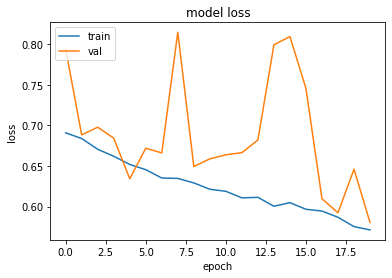

In [175]:
import matplotlib.pyplot as plt
plt.plot(historys[0]['loss'])
plt.plot(historys[0]['val_loss'])
plt.title('model loss')



plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

0
Num_samples: 480
acc:  0.7354166666666667
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 480
acc:  0.7354166666666667
2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 480
acc:  0.7354166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


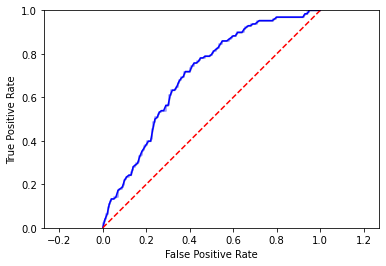

In [161]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: './model_1/0/*.hdf5',
          1: './model_1/1/*.hdf5',
          2: './model_1/2/*.hdf5',
          3: './model_1/3/*.hdf5',
          4: './model_1/4/*.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(3):
    print(iii)
    test_features= sup_DATA[RUN]['MFCCS'][ int(0.85*sup_data_size) :]
    test_extra   = sup_DATA[RUN]['EXTRA'][ int(0.85*sup_data_size) :]
    test_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*sup_data_size) :]
    test_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*sup_data_size) :]
    TEST          = sup_specGenerator(test_imgs,test_labels,batch_size=48,target_size=(64,64))
#     for file in os.listdir(path):
#         model_path = path+'/'+file
#         model_path = path+'/'+file
    model = keras.models.load_model("./downstream_resnet_32/0/019--0.528--0.485.hdf5")
    y_score = model.predict(TEST)
    fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
    
    print('Num_samples:', len(y_score))
    print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

In [138]:
def to_one_or_zero(bool):
    return 1 if bool else 0

In [140]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

for iii in range(3):
    print(iii)
    test_features= sup_DATA[RUN]['MFCCS'][ int(0.85*sup_data_size) :]
    test_extra   = sup_DATA[RUN]['EXTRA'][ int(0.85*sup_data_size) :]
    test_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*sup_data_size) :]
    test_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*sup_data_size) :]
    TEST          = sup_specGenerator(test_imgs,test_labels,batch_size=48,target_size=(64,64))
#     for file in os.listdir(path):
#         model_path = path+'/'+file
#         model_path = path+'/'+file
    model = keras.models.load_model("./downstream_pre03_class_weight_32/0/024--0.596--0.571.hdf5")
    y_score = model.predict(TEST)
    y_score = list(map(to_one_or_zero, y_score > .6))
 
    con_mat = tf.math.confusion_matrix(labels=test_labels[:len(y_score)], predictions=y_score).numpy()
    print(con_mat)
#     con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
#     con_mat_df = pd.DataFrame(con_mat_norm,
#                      index = 2, 
#                      columns = [0,1])
#     print(con_mat_df)
#     figure = plt.figure(figsize=(8, 8))
#     sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

0
[[290  62]
 [ 77  51]]
1
[[290  62]
 [ 77  51]]
2
[[290  62]
 [ 77  51]]


In [117]:
3..from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision